In [132]:
import pandas as pd
from textblob import TextBlob
import spacy
import numpy as np

nlp = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('Raw_data/lines.csv')

In [3]:
df

,name,ep_szn,title,lines
0,The boys,101,"""Cartman Gets an Anal Probe""","School days, school days, teacher's golden ru...."
1,Kyle Broflovski,101,"""Cartman Gets an Anal Probe""","Ah, damn it! My little brother's trying to fol..."
2,Ike Broflovski,101,"""Cartman Gets an Anal Probe""",Ee gko zeeponanner.
3,Kyle,101,"""Cartman Gets an Anal Probe""","Ike, you can't come to school with me. [Ike ch..."
4,Eric Cartman,101,"""Cartman Gets an Anal Probe""","Yeah, go home you little dildo!"
...,...,...,...,...
86939,Sharon,2606,"""Spring Break""","Stanley, what have I told you about playing ""W..."
86940,Stan,2606,"""Spring Break""",Aw!
86941,Garrison,2606,"""Spring Break""","Oh, Rick!"
86942,Garrison,2606,"""Spring Break""",I don't want to go through all that again. I j...


# Pre-processing

* Inspect NaN values and decide what to do with these rows
* Split strings so that we're not just dealing with one big string for each line
* Remove punctuation from all of the lines

In [4]:
df.isna().sum()

name      31
ep_szn     0
title      0
lines      6
dtype: int64

In [5]:
# Let's have a look at some..
# We can see we have some lines with no speaker and also some "stage direction" type of comments

df[df.name.isna()].head(5)

,name,ep_szn,title,lines
53949,NaN,1212,"""About Last Night...""","Boom, baby!"
75959,NaN,2008,"""Members Only""",[the machine closes enseals Garrison]
75968,NaN,2008,"""Members Only""","[Cartman, Heidi, and the secretary turn their ..."
76089,NaN,2008,"""Members Only""",[everyone continues walking]
76213,NaN,2009,"""Not Funny""",[crowd stops chattering]


In [6]:
# & keeps rows where ALL conditions are True

df = df[~(df.name.isna()) & (~df.lines.isna())].reset_index(drop = True)

In [7]:
# Check it's worked

df.isna().sum()

name      0
ep_szn    0
title     0
lines     0
dtype: int64

In [8]:
df.loc[0, 'lines']

"School days, school days, teacher's golden ru... [Ike runs to the team]"

In [9]:
# Before we go ahead and strip all punctuation we want to remove all of the "stage direction" stuff

df['lines'].replace(to_replace="\[.*?]", value="", regex=True, inplace=True)

/var/folders/dm/468m4xf52c71yhldz5ck50pw0000gn/T/ipykernel_17244/444882383.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lines'].replace(to_replace="\[.*?]", value="", regex=True, inplace=True)


In [10]:
# Let's check if it worked

df.loc[0, 'lines']

"School days, school days, teacher's golden ru... "

In [11]:
df[df.lines == " God?? I can't do that. I haven't spoken to God in like, 5000 years."]

,name,ep_szn,title,lines
20680,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...


In [12]:
df['string_split'] = df['lines'].str.split()

In [13]:
df.loc[0, 'string_split']

['School', 'days,', 'school', 'days,', "teacher's", 'golden', 'ru...']

In [14]:
English_punctuation = "!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-"      # Define a variable with all the punctuation to remove.
print(English_punctuation)                                     # Print that defined variable, just to check it is correct.
print("...") 

def remove_punctuation(from_text):                           # Had to define a function to iterate over the strings in a row
    table = str.maketrans('', '', English_punctuation)       # The python function 'maketrans' creates a table that maps
    stripped = [w.translate(table) for w in from_text]        # the punctation marks to 'None'. Print the table to check. 
    return stripped

!"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-
...


In [15]:
df['no_punct'] = df['string_split'].apply(remove_punctuation)

# Extract names from lines

What we want to do now is find a way to pull out every name from the lines in our dataset. 
Luckily for us when we did our webscraping, the webpage was formatted in a way that the names were easy to pull out into their own column. 

So, below, you'll see that what we do is create a variable which contains a list of all our unique names in the dataset. We then create 2 empty lists:

* match = will hold the names that match those in our unique names list
* index = will hold the indexes that pertain to the row of the dataset we are iterating through

You can see we also have a counter which is set to -1, because our index starts at 0. 
Then we have a series of for loops:

* first for loop iterates through each list of split strings in the dataset
* second for loop then iterates through each indivdual string/word within each list
* third for loop then iterates through each unique name in our list of unique names

Then we have an if statement which checks if the individual string matches any name in the list of names.
If it does we then append the name to our empty match list, along with its index.

In [16]:
names = list(df.name.unique())

In [17]:
names[:5]

['The boys', 'Kyle Broflovski', 'Ike Broflovski', 'Kyle', 'Eric Cartman']

Executing the cell below may take a few minutes as it's iterating through 86907 lines which contain 11 strings on average.

In [18]:
match = []
index = []
counter = -1

for lines in df.no_punct:
    counter += 1
    for word in lines:
        for i in names:
            if word == i:
                match.append(i)
                index.append(counter)

                

In [19]:
# Let's check out our match list

match[:10]

['Ike',
 'Dude',
 'Cartman',
 'Kenny',
 'Dude',
 'Ike',
 'Cartman',
 'Dude',
 'Cartman',
 'Chef']

In [20]:
# Let's look at our index list

index[:10]

[3, 5, 7, 11, 14, 15, 18, 28, 31, 37]

In [21]:
# Seems right! Although may need to deal with "Dude"

df.loc[index[:10]]

,name,ep_szn,title,lines,string_split,no_punct
3,Kyle,101,"""Cartman Gets an Anal Probe""","Ike, you can't come to school with me.","[Ike,, you, can't, come, to, school, with, me.]","[Ike, you, can't, come, to, school, with, me]"
5,Kyle,101,"""Cartman Gets an Anal Probe""","Dude, don't call my brother a dildo!","[Dude,, don't, call, my, brother, a, dildo!]","[Dude, don't, call, my, brother, a, dildo]"
7,Kyle,101,"""Cartman Gets an Anal Probe""","Well, I don't know... and I'll bet Cartman doe...","[Well,, I, don't, know..., and, I'll, bet, Car...","[Well, I, don't, know, and, I'll, bet, Cartman..."
11,Stan,101,"""Cartman Gets an Anal Probe""","What's a dildo, Kenny?","[What's, a, dildo,, Kenny?]","[What's, a, dildo, Kenny]"
14,Stan,101,"""Cartman Gets an Anal Probe""","Dude, that kicks ass!","[Dude,, that, kicks, ass!]","[Dude, that, kicks, ass]"
15,Kyle,101,"""Cartman Gets an Anal Probe""","Yeah, check this one out. Ready Ike? Kick the ...","[Yeah,, check, this, one, out., Ready, Ike?, K...","[Yeah, check, this, one, out, Ready, Ike, Kick..."
18,Stan,101,"""Cartman Gets an Anal Probe""","Whoa, Cartman! Looks like you didn't get much ...","[Whoa,, Cartman!, Looks, like, you, didn't, ge...","[Whoa, Cartman, Looks, like, you, didn't, get,..."
28,Stan,101,"""Cartman Gets an Anal Probe""",Dude! Visitors!,"[Dude!, Visitors!]","[Dude, Visitors]"
31,Stan,101,"""Cartman Gets an Anal Probe""","That wasn't a dream Cartman, those were visitors!","[That, wasn't, a, dream, Cartman,, those, were...","[That, wasn't, a, dream, Cartman, those, were,..."
37,Boys,101,"""Cartman Gets an Anal Probe""","Hey, Chef.","[Hey,, Chef.]","[Hey, Chef]"


In [22]:
# Let's create our filtered dataset using our indexes

filtered = df.loc[index]

In [23]:
# Let's assign our list of matches to a new column

filtered['matches'] = match

In [24]:
# We have duplicate indexes which is annoying

filtered[filtered.lines == " God?? I can't do that. I haven't spoken to God in like, 5000 years."]

,name,ep_szn,title,lines,string_split,no_punct,matches
20680,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God
20680,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God


In [25]:
# Let's check it out
# Looks like we should reset our index!

filtered[['lines', 'matches']].head()

,lines,matches
3,"Ike, you can't come to school with me.",Ike
5,"Dude, don't call my brother a dildo!",Dude
7,"Well, I don't know... and I'll bet Cartman doe...",Cartman
11,"What's a dildo, Kenny?",Kenny
14,"Dude, that kicks ass!",Dude


In [26]:
filtered[filtered.lines == " God?? I can't do that. I haven't spoken to God in like, 5000 years."]

,name,ep_szn,title,lines,string_split,no_punct,matches
20680,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God
20680,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God


In [27]:
# Let's reset our index

filtered = filtered.reset_index(drop = True)

In [28]:
# Now we don't have duplicate indexes!

filtered[filtered.lines == " God?? I can't do that. I haven't spoken to God in like, 5000 years."]

,name,ep_szn,title,lines,string_split,no_punct,matches
7643,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God
7644,Satan,411,"""Probably""",God?? I can't do that. I haven't spoken to Go...,"[God??, I, can't, do, that., I, haven't, spoke...","[God, I, can't, do, that, I, haven't, spoken, ...",God


# Nearly done...

Now all we need to do in order to make this dataset network-ready is to compute number of times each character mentions another character.

In [29]:
counts = filtered[['name', 'matches']].value_counts().reset_index()

In [131]:
counts

,name,matches,count
0,Cartman,Kyle,1011
1,Cartman,Butters,567
2,Kyle,Cartman,564
3,Stan,Dude,495
4,Cartman,Kenny,401
...,...,...,...
10132,Memberberry 4,Mickey,1
10133,Memberberry 3,Death,1
10134,Memberberry 2,Tubbs,1
10135,Memberberry 1,Member,1


In [151]:
counts.name.nunique()

2268

In [152]:
counts.matches.nunique()

951

In [135]:
arr = counts.set_index(['name', 'matches'])['count'].unstack().values

In [150]:
arr.shape

(2268, 951)

In [154]:
arr.ndim

2

In [143]:
for i in arr:
    for x in i:
        if x > 50:
            print(x)

52.0
94.0
198.0
54.0
68.0
51.0
66.0
244.0
567.0
57.0
127.0
92.0
229.0
61.0
388.0
90.0
129.0
73.0
401.0
1011.0
203.0
62.0
84.0
220.0
164.0
90.0
108.0
96.0
109.0
153.0
564.0
70.0
83.0
361.0
149.0
180.0
69.0
162.0
59.0
258.0
183.0
79.0
61.0
94.0
63.0
67.0
76.0
96.0
195.0
59.0
272.0
67.0
201.0
120.0
141.0
125.0
167.0
373.0
99.0
281.0
495.0
146.0
118.0
193.0
320.0
89.0
75.0
132.0
83.0
79.0


In [30]:
counts.head(20)

,name,matches,count
0,Cartman,Kyle,1011
1,Cartman,Butters,567
2,Kyle,Cartman,564
3,Stan,Dude,495
4,Cartman,Kenny,401
5,Cartman,God,388
6,Stan,Cartman,373
7,Kyle,Dude,361
8,Stan,Kyle,320
9,Stan,Dad,281


In [51]:
counts[counts.matches == 'Cartman']

,name,matches,count
2,Kyle,Cartman,564
6,Stan,Cartman,373
66,Cartman,Cartman,57
154,Butters,Cartman,22
230,Wendy,Cartman,16
...,...,...,...
9807,Mike,Cartman,1
9865,Mosquito,Cartman,1
9952,Mayor McDaniels,Cartman,1
10046,Mephesto Tryout,Cartman,1


In [32]:
pivoted = counts.pivot(index = 'name', columns = 'matches', values = 'count')

In [155]:
out = pivoted.combine_first(pivoted.T)

In [156]:
out

,"""Ash""","""Beaky Buzzard""","""Brokaw""","""Cupid Ye""","""Droopy Dawg""","""Eight""","""Kenny""","""Pete Puma""","""Porky Pig""",# 10,...,YourMomsTits,Zazul,Zeus,Zombie,Zytar,driver,f*ther Maxi,instructor,woman,worker
"""Ash""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Beaky Buzzard""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Brokaw""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Cupid Ye""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Droopy Dawg""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f*ther Maxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
instructor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
woman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
pivot_table = counts.pivot_table(index = 'name', columns = 'matches', values = 'count', fill_value = 0)

In [129]:
pivot_table

matches,Adam,Adams,Adolf,Adults,Agent,Aguilar,Al,Alan,Alarm,Alec,...,Yolanda,YourMomsTits,Zazul,Zeus,Zombie,Zytar,driver,instructor,woman,worker
name,,,,,,,,,,,,,,,,,,,,,
"""Ash""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Beaky Buzzard""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Brokaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Cupid Ye""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Droopy Dawg""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zazul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zeus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f*ther Maxi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
out = pivot_table.combine_first(pivot_table.T)

In [159]:
out.replace(np.nan, 0)

,"""Ash""","""Beaky Buzzard""","""Brokaw""","""Cupid Ye""","""Droopy Dawg""","""Eight""","""Kenny""","""Pete Puma""","""Porky Pig""",# 10,...,YourMomsTits,Zazul,Zeus,Zombie,Zytar,driver,f*ther Maxi,instructor,woman,worker
"""Ash""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Beaky Buzzard""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Brokaw""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Cupid Ye""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Droopy Dawg""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
driver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f*ther Maxi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
instructor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
woman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
all_characters = set(counts['name']).union(set(counts['matches']))

In [176]:
len(all_characters)

2586

In [177]:
pivoted_2 = pivoted.reindex(index=all_characters, columns=all_characters, fill_value=0)

In [180]:
pivoted_2 = pivoted_2.replace(np.nan, 0)

In [185]:
import nxviz as nviz

# from nviz.plots import MatrixPlot

In [187]:
from nxviz import MatrixPlot

In [190]:
import networkx as nx
import matplotlib.pyplot as plt

In [191]:
G = nx.DiGraph(pivoted_2)

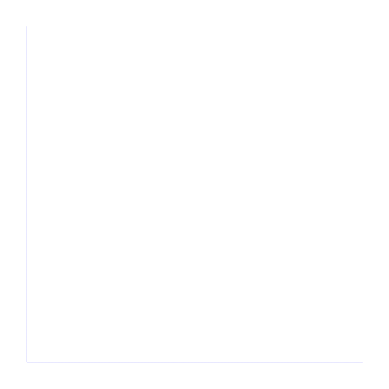

In [203]:
m = MatrixPlot(G)


TypeError: BasePlot.draw() takes 0 positional arguments but 1 was given

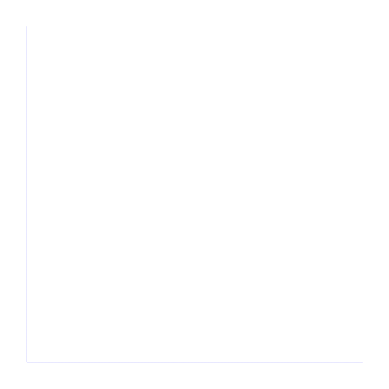

<Figure size 800x800 with 0 Axes>

In [212]:
# Convert the pivoted DataFrame to a directed graph
G = nx.from_pandas_adjacency(pivoted_2, create_using=nx.DiGraph)

# Create a MatrixPlot object
m = MatrixPlot(G)

# Display the plot
plt.figure(figsize=(8, 8))  # Optional: Set the plot size
m.draw()
plt.show()

In [205]:
plt.show()

In [168]:
out.Cartman

"Ash"              0.0
"Beaky Buzzard"    0.0
"Brokaw"           0.0
"Cupid Ye"         0.0
"Droopy Dawg"      0.0
                  ... 
driver             5.0
f*ther Maxi        0.0
instructor         0.0
woman              0.0
worker             4.0
Name: Cartman, Length: 2586, dtype: float64

In [160]:
out.Cartman.value_counts().nsmallest(50)

Cartman
37.0        1
57.0        1
46.0        1
564.0       1
61.0        1
62.0        1
11.0        1
28.0        1
373.0       1
22.0        1
14.0        2
10.0        2
12.0        2
7.0         2
16.0        2
26.0        2
9.0         3
8.0         5
5.0         8
6.0         9
4.0        10
3.0        24
2.0        52
1.0       117
0.0      2336
Name: count, dtype: int64

"Ash"              NaN
"Beaky Buzzard"    NaN
"Brokaw"           NaN
"Cupid Ye"         NaN
"Droopy Dawg"      NaN
                  ... 
driver             0.0
f*ther Maxi        NaN
instructor         0.0
woman              0.0
worker             0.0
Name: "Ash", Length: 2586, dtype: float64
"Ash"              NaN
"Beaky Buzzard"    NaN
"Brokaw"           NaN
"Cupid Ye"         NaN
"Droopy Dawg"      NaN
                  ... 
driver             0.0
f*ther Maxi        NaN
instructor         0.0
woman              0.0
worker             0.0
Name: "Beaky Buzzard", Length: 2586, dtype: float64
"Ash"              NaN
"Beaky Buzzard"    NaN
"Brokaw"           NaN
"Cupid Ye"         NaN
"Droopy Dawg"      NaN
                  ... 
driver             0.0
f*ther Maxi        NaN
instructor         0.0
woman              0.0
worker             0.0
Name: "Brokaw", Length: 2586, dtype: float64


In [100]:
pivoted

matches,Adam,Adams,Adolf,Adults,Agent,Aguilar,Al,Alan,Alarm,Alec,...,Yolanda,YourMomsTits,Zazul,Zeus,Zombie,Zytar,driver,instructor,woman,worker
name,,,,,,,,,,,,,,,,,,,,,
"""Ash""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Beaky Buzzard""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Brokaw""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Cupid Ye""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Droopy Dawg""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zazul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f*ther Maxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
pivoted.index

Index(['"Ash"', '"Beaky Buzzard"', '"Brokaw"', '"Cupid Ye"', '"Droopy Dawg"',
       '"Eight"', '"Kenny"', '"Pete Puma"', '"Porky Pig"', '# 10',
       ...
       'Yelper 4', 'Younger Boy', 'Younger daughter', 'Younger man',
       'YourMomsTits', 'Zazul', 'Zeus', 'f*ther Maxi', 'instructor', 'woman'],
      dtype='object', name='name', length=2268)

In [50]:
pivoted.Cartman.value_counts().nsmallest(50)

Cartman
22.0      1
57.0      1
564.0     1
8.0       1
12.0      1
10.0      1
373.0     1
16.0      1
14.0      2
9.0       2
4.0       4
5.0       5
6.0       6
3.0      11
2.0      28
1.0      82
Name: count, dtype: int64

In [56]:
cartman = pivoted[pivoted.index == 'Cartman']

In [117]:
for i in cartman.loc[:, 'Adam']:
    print(i)

4.0


In [106]:
b = cartman.iloc[0]

In [108]:
b

matches
Adam          4.0
Adams         NaN
Adolf         1.0
Adults        1.0
Agent         NaN
             ... 
Zytar         NaN
driver        5.0
instructor    NaN
woman         9.0
worker        4.0
Name: Cartman, Length: 951, dtype: float64

In [126]:
for i in cartman.columns:
   b = cartman.loc[:, i]
   for num in b:
       if num > 50:
           print(f"{num} and {i}")

244.0 and All
567.0 and Butters
57.0 and Cartman
127.0 and Clyde
92.0 and Craig
229.0 and Dude
61.0 and Eric
388.0 and God
90.0 and Heidi
129.0 and Jesus
73.0 and Jimmy
401.0 and Kenny
1011.0 and Kyle
203.0 and Mom
62.0 and Right
84.0 and Scott
220.0 and Stan
164.0 and Tolkien
90.0 and Wendy


In [102]:
for i in cartman.iloc[0]:
    if i > 100:
        print(i)

244.0
567.0
127.0
229.0
388.0
129.0
401.0
1011.0
203.0
220.0
164.0


In [127]:
pivoted

matches,Adam,Adams,Adolf,Adults,Agent,Aguilar,Al,Alan,Alarm,Alec,...,Yolanda,YourMomsTits,Zazul,Zeus,Zombie,Zytar,driver,instructor,woman,worker
name,,,,,,,,,,,,,,,,,,,,,
"""Ash""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Beaky Buzzard""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Brokaw""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Cupid Ye""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Droopy Dawg""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zazul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f*ther Maxi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rudimentary network

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import xlrd

In [ ]:
G = nx.Graph()
names = []

zipped = list(zip(red['name'], red['matches']))

In [ ]:
G.add_edges_from(zipped)

In [ ]:
nx.draw(G, with_labels = True)

In [ ]:
plt.show()

# Networkx

In [ ]:
b[(b.name == 'Cartman') & (b.matches == 'Butters')]

In [ ]:
G2 = nx.from_pandas_edgelist(b, source = "name", target = "matches", edge_attr = "count", create_using = nx.Graph())

In [ ]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G2)
nx.draw(G2, with_labels = True, node_color = 'skyblue', edge_cmap=plt.cm.Blues, pos = pos, font_size = 8, node_size = 150)
plt.show()

In [ ]:
total_nodes = pd.concat([b['name'], b['matches']]).nunique()
print(total_nodes)

In [ ]:
top_counts = b[b['count'] > 10]

In [ ]:
len(top_counts)

In [ ]:
total_nodes = pd.concat([top_counts['name'], top_counts['matches']]).nunique()
print(total_nodes)

In [ ]:
G3 = nx.from_pandas_edgelist(top_counts, source = "name", target = "matches", edge_attr = "count", create_using = nx.Graph())

In [ ]:
plt.figure(figsize = (10,10))
pos = nx.kamada_kawai_layout(G3)
nx.draw(G3, with_labels = True, node_color = 'skyblue', edge_cmap=plt.cm.Blues, pos = pos, font_size = 8, node_size = 150)
plt.show()

In [ ]:
nx.degree_centrality(G3)

In [ ]:
9759 / 10137 * 100

In [ ]:
# from pyvis.network import Network
# net = Network(notebook = True, width="1000px", height= "700px", bgcolor = "#222222", font_color='white')
# net.from_nx(G2)
# net.show("southpark.html")

# X_array stuff

In [ ]:
# xarray

ds = filtered.to_xarray()

In [ ]:
ds.set_coords(['name', 'matches', 'n_mentions'])

In [ ]:
for i in na:
    if i == 'Sorry':
        print(i)

Things to consider:

The boys use "Dude" a lot throughout to refer to each other, but in a few of the episodes (3) there is a generic "Dude" character, and he does reference others. Should we filter these out?

We also need to filter out "Sorry". It appears once in 

In [ ]:
df_c[df_c.name == 'Sorry'].head(70)

In [ ]:
pd.set_option('display.max_rows', 500)

df_c[df_c.ep_szn == 218]

# Extract named entities

In [ ]:
df_c['lines'].replace(to_replace="\[.*?]", value="", regex=True, inplace=True)

In [ ]:
df_c['lines'][98]

In [ ]:
b = df_c.lines.tolist()

In [ ]:
ent_list = []

for i in b[:5]:
    print("aye", i)
    doc = nlp(i) 
    for entity in doc.ents:
        ent_list.append(entity.text)
    else:
        ent_list.append("None")
        

In [ ]:
ent_list

In [ ]:
sent_ent = []


for line, char in zip(df_c.lines, df_c.name):
    doc = nlp(line)
    entity_list = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    sent_ent.append({"name": char, "line": line, "entities": entity_list})
    
    for ent in doc.ents:
        print(ent.label_)
#     doc = nlp(i)
#     for entity in doc.ents:
#         entity_list.append(entity.text)
#     else:
#         entity_list.append("None")

In [ ]:
sent_ent

In [ ]:
for i in sent_ent[:10]:
    print(i['entities'])

In [ ]:
for i in sent_ent[:3]:
    print(i)

In [ ]:
df_c.name

In [ ]:
entity_list

In [ ]:
df_c['Entities'] = entity_list

In [ ]:
na_removed

In [ ]:
na_removed['line_sent'] = na_removed['lines'].apply(lambda x: TextBlob(x).sentiment[0])

In [ ]:
na_removed

In [ ]:
cartman = na_removed[na_removed.name == 'Cartman']

In [ ]:
cartman

In [ ]:
cartman.line_sent.mean()

In [ ]:
cartman.line_sent.sum() / len(cartman)

In [ ]:
zero_removed = cartman[cartman.line_sent != 0.0000]

In [ ]:
zero_removed.line_sent.mean()

In [ ]:
kyle = na_removed[na_removed.name == 'Kyle']

In [ ]:
kyle.line_sent.sum() / len(kyle)

In [ ]:
wendy = na_removed[na_removed.name == 'Wendy']

In [ ]:
wendy

In [ ]:
wendy.line_sent.sum() / len(wendy)

In [ ]:
zero_removed = sheila[sheila.line_sent != 0.0000]

In [ ]:
zero_removed.line_sent.sum() / len(zero_removed)

In [ ]:
kenny

In [ ]:
kenny = na_removed[na_removed.name == 'Kenny']

In [ ]:
kenny.line_sent.mean()

In [ ]:
zero_removed = kenny[kenny.line_sent != 0.0000]

In [ ]:
zero_removed.line_sent.mean()

In [ ]:
garrison = na_removed[na_removed.name == 'Garrison']

In [ ]:
garrison

In [ ]:
garrison.line_sent.mean()

In [ ]:
means = []
names = []

for i in na_removed.name.unique():
    names.append(i)
    unique = na_removed[na_removed.name == i]
    mean = unique.line_sent.mean()
    means.append(mean)
    

In [ ]:
df = pd.DataFrame(list(zip(names, means)),
               columns =['Name', 'Mean'])

In [ ]:
df.sort_values(by = 'Mean', ascending = False)[:50]

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

df.name.unique()